In [91]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#import libraries 
import pandas as pd
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer
from sklearn.metrics import f1_score

from sklearn.svm import SVC

import xgboost as XGB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p

from scipy.stats import boxcox_normmax

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression




In [0]:
train_df = pd.read_csv('gdrive/My Drive/Colab Notebooks/Kaggle/House_Prices/train.csv')
test_df = pd.read_csv('gdrive/My Drive/Colab Notebooks/Kaggle/House_Prices/test.csv')


# Goal & Metric

- The goal is to successfully predict housing prices based on the given information obtained in the datasets. 

- The metric in which we evaluate this success is the  Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. 

# What to do 



1.   Analyze the price distribution. 
2.   Analyze the correlation between all variables
3.   Make the price distribution normally distributed.
4.   Remove Outliers 
5.   Fill in missing values 
6.   For all numeric features, normalize them. 
7.   Feature engineering 
8.   Feature transformations
9.   Encode categorial features 






# EDA 

## Is the price normally distributed? 

Machine learning algorithms are good at predictions, however when the data is not normally distributed the algorithms work less well. Therefore we will analyze the distribution of the applicable variables and see if we can modify the distribution with for example taking the log of each value. 


We will begin with analyzing the target (aka the variable we want to predict), the housing price. 

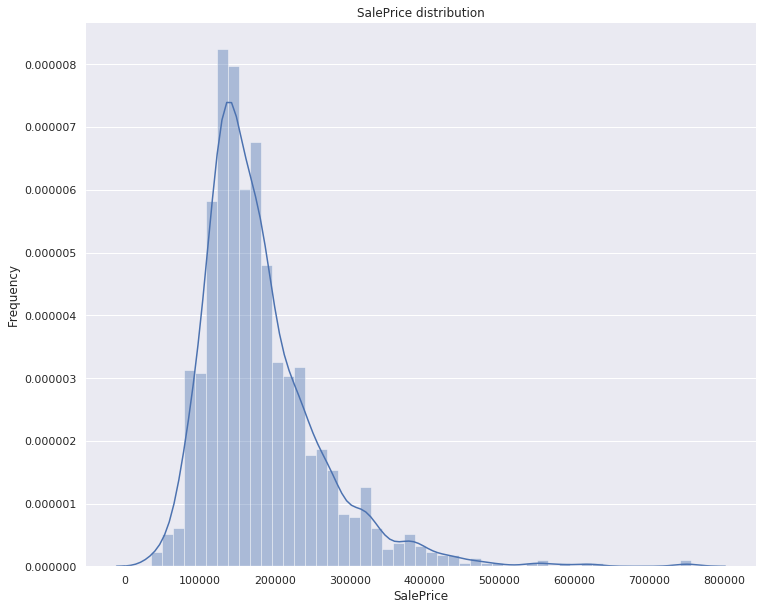

In [94]:
f, ax = plt.subplots(figsize=(12, 10))
#Check the new distribution 

sns.distplot(train_df['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

The distribution is skewed. 


In [95]:
# Skew and kurt
print("Skewness: %f" % train_df['SalePrice'].skew())
print("Kurtosis: %f" % train_df['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


### Conclusion 

The distribution of the house price is skewed and this is something we will address in a later stage.

## Which features are highly correlated with the price?

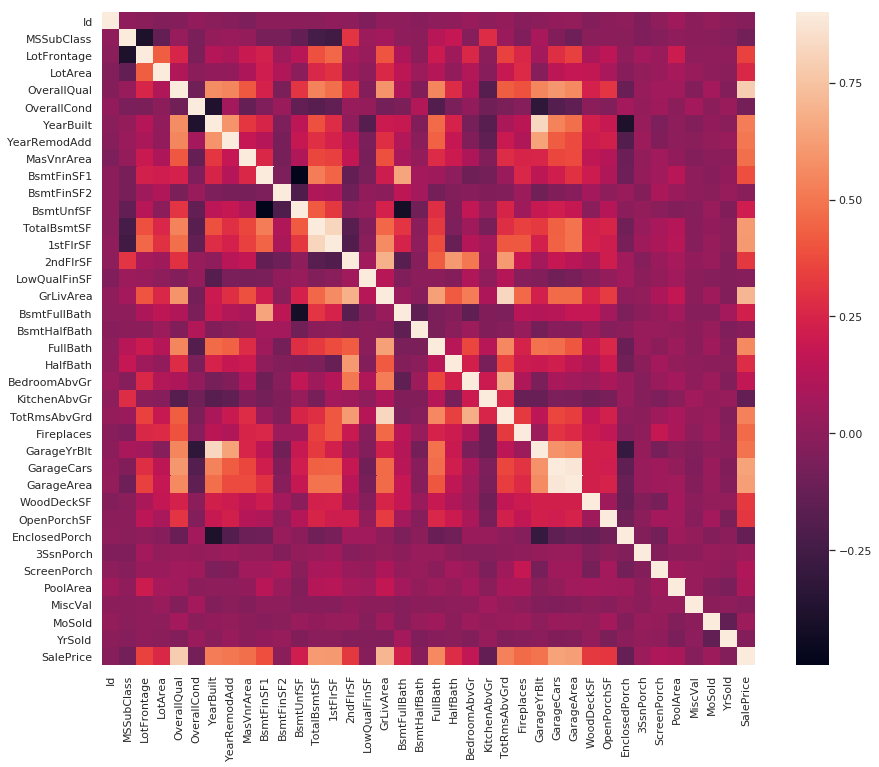

In [96]:
corr = train_df.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, square=True)

In [97]:
k = 10

corr = train_df.corr()['SalePrice'].abs()
corr.sort_values(kind="quicksort",ascending=False,inplace = True)
corr


SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
Id               0.021917
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
Name: SalePr

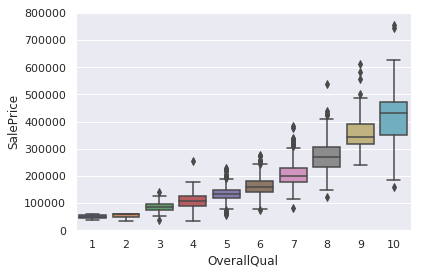

In [98]:
fig = sns.boxplot(x=train_df['OverallQual'], y="SalePrice", data=train_df)
fig.axis(ymin=0, ymax=800000);


In [99]:
print(train_df[(train_df['OverallQual']<5) & (train_df['SalePrice']>200000)].index)
print(train_df[(train_df['OverallQual']==7) & (train_df['SalePrice']>350000)].index)
print(train_df[(train_df['OverallQual']==8) & (train_df['SalePrice']>500000)].index)
print(train_df[(train_df['OverallQual']==9) & (train_df['SalePrice']>600000)].index)
print(train_df[(train_df['OverallQual']==10) & (train_df['SalePrice']>700000)].index)


Int64Index([457], dtype='int64')
Int64Index([112, 313], dtype='int64')
Int64Index([769], dtype='int64')
Int64Index([898], dtype='int64')
Int64Index([691, 1182], dtype='int64')


In [0]:
outlier_index = [457,112, 313,769,898,691,1182]


Here we can see some clear outliers over number 4,7,8,9, and 10. 

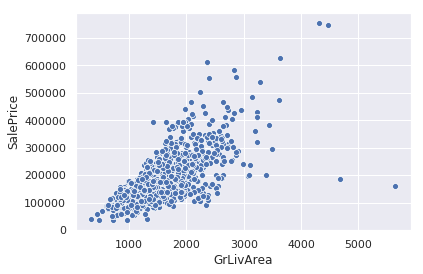

In [101]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
ax = sns.scatterplot(y="SalePrice", x="GrLivArea", data=train_df)


In [102]:
print(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<200000)].index)


Int64Index([523, 1298], dtype='int64')


In [0]:
outlier_index.extend([523, 1298])

We can see here that we have two outliers in the bottom right corner. 


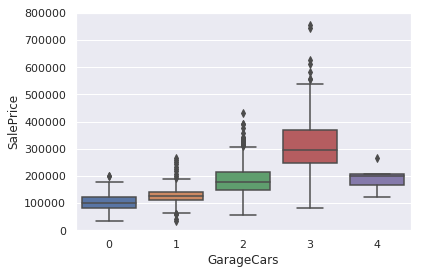

In [104]:
fig = sns.boxplot(x=train_df['GarageCars'], y="SalePrice", data=train_df)
fig.axis(ymin=0, ymax=800000);


In [105]:
print(train_df[(train_df['GarageCars']== 2) & (train_df['SalePrice']>400000)].index)
print(train_df[(train_df['GarageCars']== 3) & (train_df['SalePrice']>700000)].index)



Int64Index([496], dtype='int64')
Int64Index([691, 1182], dtype='int64')


In [0]:
outlier_index.extend([496, 691, 1182])

Here we can see some clear outliers when garagecars = 2 and garagecars = 4.

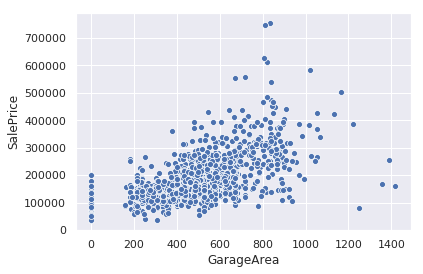

In [107]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
ax = sns.scatterplot(y="SalePrice", x="GarageArea", data=train_df)

In [108]:
print(train_df[(train_df['GarageArea']>1200) & (train_df['SalePrice']<300000)].index)


Int64Index([581, 1061, 1190, 1298], dtype='int64')


In [0]:
outlier_index.extend([581, 1061, 1190, 1298])

Here we see some datapoints in the bottom right corner that are outliers. 

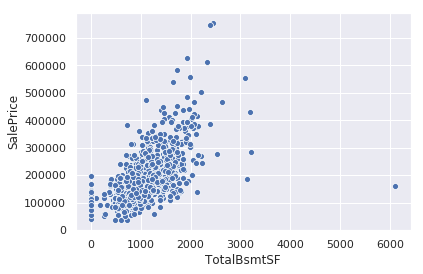

In [110]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
ax = sns.scatterplot(y="SalePrice", x="TotalBsmtSF", data=train_df)

In [111]:
print(train_df[(train_df['TotalBsmtSF']>6000) & (train_df['SalePrice']<300000)].index)


Int64Index([1298], dtype='int64')


In [0]:
outlier_index.extend([1298])

Here we can clearly see one outlier in the bottom right corner.

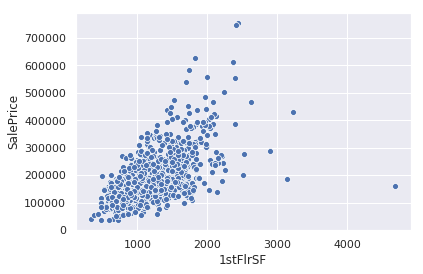

In [113]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
ax = sns.scatterplot(y="SalePrice", x="1stFlrSF", data=train_df)

In [114]:
print(train_df[(train_df['1stFlrSF']>4000) & (train_df['SalePrice']<200000)].index)


Int64Index([1298], dtype='int64')


In [0]:
outlier_index.extend([1298])

Here we see one outlier in the middle right. 

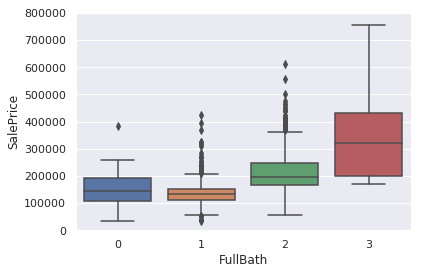

In [116]:
fig = sns.boxplot(x=train_df['FullBath'], y="SalePrice", data=train_df)
fig.axis(ymin=0, ymax=800000);



In [117]:
print(train_df[(train_df['FullBath'] == 0 ) & (train_df['SalePrice']>350000)].index)
print(train_df[(train_df['FullBath'] == 1 ) & (train_df['SalePrice']>350000)].index)
print(train_df[(train_df['FullBath'] == 2 ) & (train_df['SalePrice']>500000)].index)




Int64Index([53], dtype='int64')
Int64Index([378, 664, 1228], dtype='int64')
Int64Index([178, 440, 898], dtype='int64')


In [0]:
outlier_index.extend([53,378, 664, 1228,178, 440, 898])

We have one outliers above fullbath = 0, and some above fullbath = 1 and fullbath = 2. 

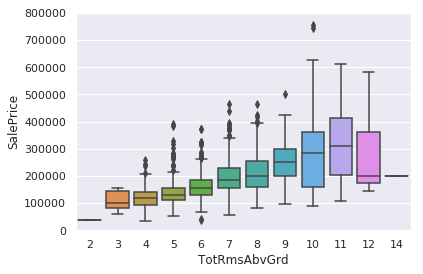

In [119]:
fig = sns.boxplot(x=train_df['TotRmsAbvGrd'], y="SalePrice", data=train_df)
fig.axis(ymin=0, ymax=800000);



In [120]:
print(train_df[(train_df['TotRmsAbvGrd'] == 5 ) & (train_df['SalePrice']>350000)].index)
print(train_df[(train_df['TotRmsAbvGrd'] == 6 ) & (train_df['SalePrice']>350000)].index)
print(train_df[(train_df['TotRmsAbvGrd'] == 7 ) & (train_df['SalePrice']>400000)].index)
print(train_df[(train_df['TotRmsAbvGrd'] == 8 ) & (train_df['SalePrice']>450000)].index)
print(train_df[(train_df['TotRmsAbvGrd'] == 9 ) & (train_df['SalePrice']>500000)].index)
print(train_df[(train_df['TotRmsAbvGrd'] == 10 ) & (train_df['SalePrice']>700000)].index)



Int64Index([53, 1181], dtype='int64')
Int64Index([151, 481], dtype='int64')
Int64Index([473, 1243], dtype='int64')
Int64Index([1373], dtype='int64')
Int64Index([178], dtype='int64')
Int64Index([691, 1182], dtype='int64')


In [0]:
outlier_index.extend([53, 1181,151, 481,473, 1243,1373,178,691, 1182])

Some outliers above 5, 6, 7, 8, 9, and 10. 


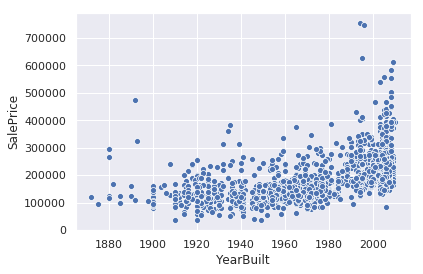

In [122]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
ax = sns.scatterplot(y="SalePrice", x="YearBuilt", data=train_df)
        
     

In [123]:
print(train_df[(train_df['YearBuilt'] < 1900 ) & (train_df['SalePrice']>400000)].index)
print(train_df[(train_df['YearBuilt'] > 1980 ) & (train_df['SalePrice']>700000)].index)



Int64Index([185], dtype='int64')
Int64Index([691, 1182], dtype='int64')


In [0]:
outlier_index.extend([185,691,1182])

One outlier in yearBuilt = ~1890 and also two point in ~1990.

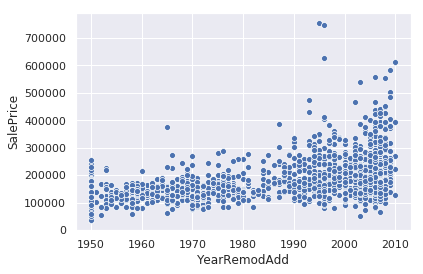

In [125]:

ax = sns.scatterplot(y="SalePrice", x="YearRemodAdd", data=train_df)
        
     

In [126]:
print(train_df[(train_df['YearRemodAdd'] > 1990 ) & (train_df['SalePrice']>700000)].index)


Int64Index([691, 1182], dtype='int64')


In [0]:
outlier_index.extend([691,1182])

Same outliers as in yearBuilt.

## Make the SalePrice normally distributed

In [0]:
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

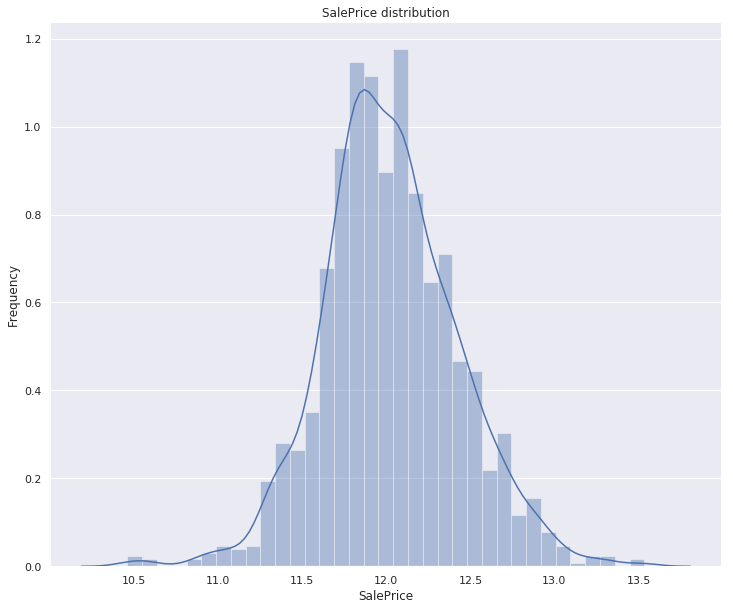

In [129]:
f, ax = plt.subplots(figsize=(12, 10))
#Check the new distribution 
sns.distplot(train_df['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

In [130]:
# Skew and kurt
print("Skewness: %f" % train_df['SalePrice'].skew())
print("Kurtosis: %f" % train_df['SalePrice'].kurt())

Skewness: 0.121347
Kurtosis: 0.809519


As we can see the skewness of the SalePrice is a lot better now. The distribution looks a lot more normally distributed. 

In [131]:
# Remove the Ids from train and test, as they are unique for each row and hence not useful for the model
train_ID = train_df['Id']
test_ID = test_df['Id']
train_df.drop(['Id'], axis=1, inplace=True)
test_df.drop(['Id'], axis=1, inplace=True)
train_df.shape, test_df.shape

((1460, 80), (1459, 79))

## Out with the Outliers

In [132]:
outlier_index_set = list(set(outlier_index))
print('number of outliers:', len(outlier_index_set))

number of outliers: 26


In [133]:
outlier_index_set

[769,
 898,
 523,
 1298,
 151,
 664,
 1181,
 1182,
 1061,
 1190,
 178,
 691,
 53,
 440,
 313,
 185,
 581,
 457,
 1228,
 473,
 1243,
 1373,
 481,
 112,
 496,
 378]

In [0]:
train_df.drop(outlier_index_set,inplace = True)
train_df.reset_index(drop = True, inplace=True)


In [135]:
train_df.shape

(1434, 80)

# Split the dataset

In [136]:
# Split features and labels
train_labels = train_df['SalePrice'].reset_index(drop=True)
train_features = train_df.drop(['SalePrice'], axis=1)
test_features = test_df

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(2893, 79)

# Dealing with missing values 

In [0]:
missing = all_features.isna().sum().sort_values(ascending=False)

In [138]:
missing[missing > 0]

PoolQC          2885
MiscFeature     2789
Alley           2695
Fence           2324
FireplaceQu     1419
LotFrontage      482
GarageCond       159
GarageQual       159
GarageYrBlt      159
GarageFinish     159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        23
MasVnrArea        22
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
BsmtUnfSF          1
TotalBsmtSF        1
Exterior1st        1
SaleType           1
Electrical         1
KitchenQual        1
GarageArea         1
GarageCars         1
dtype: int64

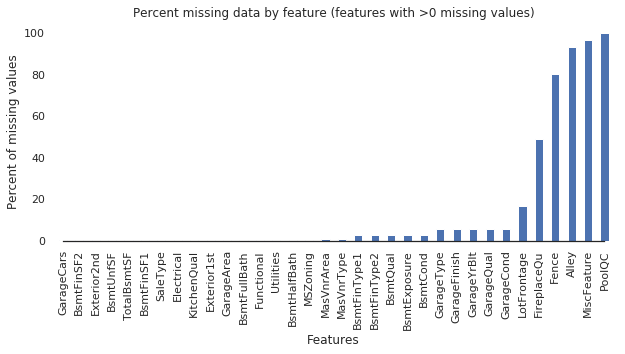

In [139]:
# Visualize missing values
sns.set_style("white")
f, ax = plt.subplots(figsize=(10, 4))
sns.set_color_codes(palette='deep')


missing = (missing[missing > 0]*100) /all_features.shape[0]
missing.sort_values(inplace=True)
missing.plot.bar(color="b")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature (features with >0 missing values)")
sns.despine(trim=True, left=True)

There is 5 features with more than 50% of the data missing;

- PoolQC
- MiscFeature
- Alley
- Fence 
- FireplaceQu

Then the question is, **do the missing values mean something**? 

For example, the missing value in PoolQuality means that there is no pool. So the missing values is not simpy a random data entry that is non existant. 

In [0]:
# Some of the non-numeric predictors are stored as numbers; convert them into strings 
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)

In [0]:
def handle_missing(features):
    # the data description states that NA refers to typical ('Typ') values
    features['Functional'] = features['Functional'].fillna('Typ')
    # Replace the missing values in each of the columns below with their mode
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # the data description stats that NA refers to "No Pool"
    features["PoolQC"] = features["PoolQC"].fillna("None")
    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    # Replacing the missing values with None
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    # NaN values for these categorical basement features, means there's no basement
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
        
    # Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # We have no particular intuition around how to fill in the rest of the categorical features
    # So we replace their missing values with None
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('None'))
        
    # And we do the same thing for numerical features, but this time with 0s
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features

all_features = handle_missing(all_features)  

In [142]:
missing = all_features.isna().sum().sort_values(ascending=False)
print(missing)

SaleCondition    0
Foundation       0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
BsmtQual         0
YearRemodAdd     0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
RoofStyle        0
YearBuilt        0
Heating          0
Utilities        0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
LotConfig        0
                ..
ScreenPorch      0
GarageFinish     0
PoolArea         0
PoolQC           0
Fence            0
MiscFeature      0
MiscVal          0
MoSold           0
YrSold           0
GarageCars       0
GarageYrBlt      0
CentralAir       0
FullBath         0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
HalfBath         0
GarageType  

Wooohooo no missing values! 

# Find Skewed features 

As machine learning algorithms work better with features that are normally distributed we want to analyze which features that are not, and then try to transform them. Note that this is only true for the numerical features. 

In [0]:
#Fetch all numeric features
numeric_dtype = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_df = all_features.select_dtypes(include=numeric_dtype)

In [144]:
skew_features = numeric_df.skew().sort_values(ascending = False)
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index
print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(25)

There are 25 numerical features with Skew > 0.5 :


MiscVal          21.870257
PoolArea         18.640186
LowQualFinSF     12.366358
3SsnPorch        11.473166
LotArea          10.878069
KitchenAbvGr      4.282267
BsmtFinSF2        4.156314
EnclosedPorch     4.001140
ScreenPorch       3.966960
BsmtHalfBath      3.941838
MasVnrArea        2.639156
OpenPorchSF       2.553815
WoodDeckSF        1.824469
1stFlrSF          1.233484
LotFrontage       1.098414
BsmtFinSF1        0.966062
GrLivArea         0.965947
BsmtUnfSF         0.910533
2ndFlrSF          0.829919
TotRmsAbvGrd      0.737840
Fireplaces        0.736746
HalfBath          0.704782
BsmtFullBath      0.630934
TotalBsmtSF       0.594300
OverallCond       0.567927
dtype: float64

In [145]:
numeric_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0
1,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0
2,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0
3,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0
4,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0


In [146]:
'''
for col in skew_index.to_list():
    sns.distplot(numeric_df[col], color="b");
    print("Plotting for column {}".format(col))
    plt.show()
   
'''

'\nfor col in skew_index.to_list():\n    sns.distplot(numeric_df[col], color="b");\n    print("Plotting for column {}".format(col))\n    plt.show()\n   \n'

# Normalize the features

In [0]:
# Normalize skewed features
for i in skew_index:
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

In [0]:
numeric_df = all_features.select_dtypes(include=numeric_dtype)

In [149]:
skew_features = numeric_df.skew().sort_values(ascending = False)
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index
print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(16)

There are 16 numerical features with Skew > 0.5 :


PoolArea         16.236481
3SsnPorch         8.951826
LowQualFinSF      8.572565
MiscVal           5.244861
BsmtHalfBath      3.789010
KitchenAbvGr      3.761520
ScreenPorch       3.175151
BsmtFinSF2        2.576128
EnclosedPorch     2.141164
MasVnrArea        0.983551
2ndFlrSF          0.887139
WoodDeckSF        0.787717
HalfBath          0.739702
OpenPorchSF       0.626707
BsmtFullBath      0.624126
Fireplaces        0.560872
dtype: float64

In [150]:
''' 
for col in skew_index.to_list():
    sns.distplot(numeric_df[col], color="b");
    print("Plotting for column {}".format(col))
    plt.show()
    
'''
   

' \nfor col in skew_index.to_list():\n    sns.distplot(numeric_df[col], color="b");\n    print("Plotting for column {}".format(col))\n    plt.show()\n    \n'

As we can see it looks a bit better now :) 


## Adding & Transforming Features

In [0]:
all_features['BsmtFinType1_Unf'] = 1*(all_features['BsmtFinType1'] == 'Unf')
all_features['HasWoodDeck'] = (all_features['WoodDeckSF'] == 0) * 1
all_features['HasOpenPorch'] = (all_features['OpenPorchSF'] == 0) * 1
all_features['HasEnclosedPorch'] = (all_features['EnclosedPorch'] == 0) * 1
all_features['Has3SsnPorch'] = (all_features['3SsnPorch'] == 0) * 1
all_features['HasScreenPorch'] = (all_features['ScreenPorch'] == 0) * 1
all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond']
all_features = all_features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
all_features['YrBltAndRemod'] = all_features['YearBuilt'] + all_features['YearRemodAdd']

all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] +
                                 all_features['1stFlrSF'] + all_features['2ndFlrSF'])
all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
                               all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))
all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                              all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                              all_features['WoodDeckSF'])
all_features['TotalBsmtSF'] = all_features['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['2ndFlrSF'] = all_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
all_features['GarageArea'] = all_features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['GarageCars'] = all_features['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
all_features['LotFrontage'] = all_features['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
all_features['MasVnrArea'] = all_features['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
all_features['BsmtFinSF1'] = all_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

all_features['haspool'] = all_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['has2ndfloor'] = all_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasgarage'] = all_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasbsmt'] = all_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

Now we wil add additional features which are the log or the squared transform of the numerical variables. We do this since the ML algorithms are not suffisticated enough to know if the log/squared variable is a good predictor. 

In [0]:
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

all_features = logs(all_features, log_features)

In [0]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

squared_features = ['YearRemodAdd', 'LotFrontage_log', 
              'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log', 'GarageArea_log']
all_features = squares(all_features, squared_features)

## Encoding 

In [154]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)
print('shape:',all_features.shape)
all_features.head()


shape: (2893, 379)


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,BsmtFinType1_Unf,HasWoodDeck,HasOpenPorch,HasEnclosedPorch,Has3SsnPorch,HasScreenPorch,YearsSinceRemodel,...,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,18.509857,17.949638,7,3.993690,2003,2003,19.502690,149.581345,0.0,30.336665,474.278469,6.347298,1184.623005,0.0,9.392230,0.992133,0.000000,2,1.066399,3,0.750914,2.302296,0.000000,2003.0,2.0,548.0,0.000000,12.021943,0.000000,0.0,0.0,0.0,0.0,0,1,0,1,1,1,5,...,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,21.115200,18.396201,6,6.004194,1976,1976,54.598150,189.032374,0.0,44.725135,671.949884,6.688187,665.141633,0.0,8.921363,0.000000,0.709481,2,0.000000,3,0.750914,2.028025,0.901582,1976.0,2.0,460.0,57.048634,0.000000,0.000000,0.0,0.0,0.0,0.0,0,0,1,1,1,1,31,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,19.048815,18.962334,7,3.993690,2001,2002,17.829633,114.335289,0.0,57.728007,505.989034,6.410792,1202.210811,0.0,9.460344,0.992133,0.000000,2,1.066399,3,0.750914,2.028025,0.901582,2001.0,2.0,608.0,0.000000,9.858272,0.000000,0.0,0.0,0.0,0.0,0,1,0,1,1,1,6,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,17.588854,18.377771,7,3.993690,1915,1970,54.598150,63.625995,0.0,65.798320,424.229888,6.449148,1041.529254,0.0,9.398621,0.992133,0.000000,1,0.000000,3,0.750914,2.173392,0.901582,1998.0,3.0,642.0,0.000000,8.929516,16.108325,0.0,0.0,0.0,0.0,0,1,0,0,1,1,36,...,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,21.775752,19.832004,8,3.993690,2000,2000,25.507353,141.731025,0.0,62.082413,615.770556,6.602966,1477.965066,0.0,9.787963,0.992133,0.000000,2,1.066399,4,0.750914,2.418148,0.901582,2000.0,3.0,836.0,42.834274,14.196221,0.000000,0.0,0.0,0.0,0.0,0,0,0,1,1,1,8,...,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


We will also create another dataframe that contains the same data, but normalized.

In [0]:
from sklearn import preprocessing

x = all_features.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
all_features_normalized = pd.DataFrame(x_scaled)

In [156]:
all_features_normalized.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378
0,0.239461,0.310226,0.666667,0.536588,0.949275,0.883333,0.347591,0.222939,0.0,0.193341,0.176659,0.350794,0.409144,0.0,0.579296,0.336493,0.00000,0.50,0.47851,0.375,0.460578,0.648294,0.000000,0.907567,0.4,0.322767,0.000000,0.290688,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.112903,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.304027,0.334430,0.555556,0.888322,0.753623,0.433333,1.000000,0.282400,0.0,0.285042,0.263438,0.493850,0.206421,0.0,0.467098,0.000000,0.62234,0.50,0.00000,0.375,0.460578,0.497331,0.294662,0.895333,0.4,0.259366,0.365049,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.532258,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.252817,0.365114,0.666667,0.536588,0.934783,0.866667,0.316489,0.169815,0.0,0.367912,0.190580,0.377439,0.416007,0.0,0.595526,0.336493,0.00000,0.50,0.47851,0.375,0.460578,0.497331,0.294662,0.906661,0.4,0.365994,0.000000,0.238370,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.129032,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.216636,0.333431,0.666667,0.536588,0.311594,0.333333,1.000000,0.093385,0.0,0.419345,0.154687,0.393536,0.353303,0.0,0.580819,0.336493,0.00000,0.25,0.00000,0.375,0.460578,0.577343,0.294662,0.905301,0.6,0.390490,0.000000,0.215913,0.610604,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.612903,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.320398,0.412250,0.777778,0.536588,0.927536,0.833333,0.459215,0.211106,0.0,0.395663,0.238775,0.458086,0.523618,0.0,0.673591,0.336493,0.00000,0.50,0.47851,0.500,0.460578,0.712062,0.294662,0.906208,0.6,0.530259,0.274093,0.343261,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.161290,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


# Creating a test and train dataset 

In [157]:
train_labels

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
5       11.870607
6       12.634606
7       12.206078
8       11.774528
9       11.678448
10      11.771444
11      12.751303
12      11.877576
13      12.540761
14      11.964007
15      11.790565
16      11.911708
17      11.407576
18      11.976666
19      11.842236
20      12.692506
21      11.845110
22      12.345839
23      11.774528
24      11.944714
25      12.454108
26      11.811555
27      12.631344
28      12.242891
29      11.134604
          ...    
1404    12.165985
1405    11.875838
1406    11.074436
1407    12.136192
1408    11.982935
1409    12.066816
1410    11.699413
1411    12.885673
1412    11.916395
1413    12.190964
1414    12.160034
1415    11.913720
1416    12.644331
1417    11.703554
1418    12.098493
1419    11.767575
1420    11.969724
1421    12.388398
1422    11.626263
1423    11.429555
1424    11.820418
1425    12.567555
1426    11.884496
1427    11.344519
1428    12

In [158]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
X.shape, train_labels.shape, X_test.shape

((1434, 379), (1434,), (1459, 379))

In [159]:
print(len(X.columns))
print(len(set(X.columns)))
X = X.loc[:, ~X.columns.duplicated()]


379
378


In [160]:
print(len(X.columns))
print(len(set(X.columns)))

378
378


In [161]:
X_normalized = all_features_normalized.iloc[:len(train_labels), :]
X_normalized_test = all_features_normalized.iloc[len(train_labels):, :]
X_normalized.shape, train_labels.shape, X_normalized_test.shape

((1434, 379), (1434,), (1459, 379))

# Cross-validation 

In [0]:
from sklearn.model_selection import KFold
# Setup cross validation folds
kf_cv = KFold(n_splits=5, random_state=42, shuffle=True)

In [0]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf_cv))
    rmse2 = np.sqrt(-cross_val_score(model, X_normalized, train_labels, scoring="neg_mean_squared_error", cv=kf_cv))
    
    return (rmse,rmse2)

# Models

In [0]:
# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA


## Finding the best parameters for the models

I wanted to use GridsearchCV for simplicity however I didn´t provide the result in the metric of mean squared error. Therefore I settled with doing nested for loops. 


In [165]:
for n_estimators in [1100,1200,1300]:
  for max_depth in [15]:
    for min_samples_split in [5]:
      print('n_estimator:', n_estimators)
      print('max_depth:', max_depth)
      print('min_samples_split:', min_samples_split)
      estimator = RandomForestRegressor(n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            min_samples_leaf=5,
                            max_features=None,
                            oob_score=True,
                            random_state=42)

      score,score_normalized = cv_rmse(estimator)
      print("RF: {:.4f} ({:.4f})".format(score.mean(), score.std()))
      print("RF Normalized: {:.4f} ({:.4f})".format(score_normalized.mean(), score_normalized.std()))
      print('--'*30)

''' 
n_estimator: 1200
max_depth: 15
min_samples_split: 5
lightgbm: 0.1368 (0.0106)
lightgbm Normalized: 0.1369 (0.0106)
-------------------------------------'''

n_estimator: 1100
max_depth: 15
min_samples_split: 5


KeyboardInterrupt: ignored

In [0]:
for numleaves in [6]:
  for learning_rate in [0.01,0.001]:
    for n_estimators in [2000, 2500,3000]:
      for max_bin in [225,250,275]:
        print('numleaves:', numleaves)
        print('learning_rate:', learning_rate)
        print('n_estimators:', n_estimators)
        print('max_bin:', max_bin)
        estimator =LGBMRegressor(objective = 'regression',
                       numleaves = numleaves,
                       learning_rate = learning_rate,
                       n_estimators = n_estimators,
                       max_bin = max_bin,    
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)
        score,score_normalized = cv_rmse(estimator)
        print("LGBM: {:.4f} ({:.4f})".format(score.mean(), score.std()))
        print("LGBM Normalized: {:.4f} ({:.4f})".format(score_normalized.mean(), score_normalized.std()))
        print('--'*30)
        
'''
BEST ONE 
numleaves: 6
learning_rate: 0.01
n_estimators: 2000
max_bin: 250
LGBM: 0.1166 (0.0067)
LGBM Normalized: 0.1157 (0.0068)'''

In [0]:
for n_estimators in [4500,5000,5500]:
  for max_depth in [3,4,5]:
    for learning_rate in [0.01]:
      print('n_estimator:', n_estimators)
      print('max_depth:', max_depth)
      print('learning_rate:', learning_rate)
      estimator = GradientBoostingRegressor( max_features='sqrt',
                                      learning_rate = learning_rate,
                                      n_estimators = n_estimators,
                                      max_depth = max_depth,
                                      min_samples_leaf=15,
                                      min_samples_split=10,
                                      loss='huber',
                                random_state=42)

      score,score_normalized = cv_rmse(estimator)
      print("GB: {:.4f} ({:.4f})".format(score.mean(), score.std()))
      print("GB Normalized: {:.4f} ({:.4f})".format(score_normalized.mean(), score_normalized.std()))
      print('--'*30)
      
'''
n_estimator: 5500
max_depth: 3
learning_rate: 0.01
GB: 0.1106 (0.0074)
GB Normalized: 0.1109 (0.0073)
'''

In [0]:
for n_estimators in [4500,5000,5500]:
  for max_depth in [3,4,5]:
    for learning_rate in [0.01]:
      print('n_estimator:', n_estimators)
      print('max_depth:', max_depth)
      print('learning_rate:', learning_rate)
      estimator = LinearRegression( max_features='sqrt',
                                      learning_rate = learning_rate,
                                      n_estimators = n_estimators,
                                      max_depth = max_depth,
                                      min_samples_leaf=15,
                                      min_samples_split=10,
                                      loss='huber',
                                random_state=42)

      score,score_normalized = cv_rmse(estimator)
      print("GB: {:.4f} ({:.4f})".format(score.mean(), score.std()))
      print("GB Normalized: {:.4f} ({:.4f})".format(score_normalized.mean(), score_normalized.std()))
      print('--'*30)
      
'''
n_estimator: 5500
max_depth: 3
learning_rate: 0.01
GB: 0.1106 (0.0074)
GB Normalized: 0.1109 (0.0073)
'''

In [0]:
from sklearn.neighbors import KNeighborsRegressor
for k in [5,10,15,20]:
  print(k)
  estimator = KNeighborsRegressor(n_neighbors=k)
  score,score_normalized = cv_rmse(estimator)
  print("KN: {:.4f} ({:.4f})".format(score.mean(), score.std()))
  print("KN Normalized: {:.4f} ({:.4f})".format(score_normalized.mean(), score_normalized.std()))
  print('--'*30)

KN was bad so we will not use it.

In [0]:
from sklearn import linear_model
for alpha in [0.001,0.0008,0.0006,0.0004,0.0002,0.0001]:
  print(alpha)
  estimator = linear_model.Lasso(alpha=alpha,random_state = 42)
  score,score_normalized = cv_rmse(estimator)
  print("Lassa: {:.4f} ({:.4f})".format(score.mean(), score.std()))
  print("Lasso Normalized: {:.4f} ({:.4f})".format(score_normalized.mean(), score_normalized.std()))
  print('--'*30)


For this algorithm we will use alpha = 0.0004

**The best parameters for each model**

In [0]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf_cv))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)
#Lasso
lasso = linear_model.Lasso(alpha=0.0004,random_state = 42)

#Multi Layer Perceptron
mlp = MLPRegressor() 

#Linear Regression
LR = LinearRegression()




# Testing models

In [0]:
scores = {} #dictionary to save all the scores. 

In [171]:
score,score_normalized = cv_rmse(lasso)
print("Lasso: {:.4f} ({:.4f})".format(score.mean(), score.std()))
print("Lasso Normalized: {:.4f} ({:.4f})".format(score_normalized.mean(), score_normalized.std()))

scores["Lasso"] = score.mean()
scores["Lasso Normalized"] = score.mean()

Lasso: 0.1069 (0.0065)
Lasso Normalized: 0.1068 (0.0063)


In [172]:
score,score_normalized = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
print("lightgbm Normalized: {:.4f} ({:.4f})".format(score_normalized.mean(), score_normalized.std()))

scores["lightgbm"] = score.mean()
scores["lightgbm Normalized"] = score.mean()

lightgbm: 0.1150 (0.0060)
lightgbm Normalized: 0.1151 (0.0064)


In [173]:
score,score_normalized = cv_rmse(mlp)
print("mlp: {:.4f} ({:.4f})".format(score.mean(), score.std()))
print("mlp Normalized: {:.4f} ({:.4f})".format(score_normalized.mean(), score_normalized.std()))

scores["mlp"] = score.mean()
scores["mlp Normalized"] = score.mean()


mlp: 76.6320 (31.0203)
mlp Normalized: 0.1867 (0.0048)


In [174]:
score,score_normalized = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
print("xgboost Normalized: {:.4f} ({:.4f})".format(score_normalized.mean(), score_normalized.std()))

scores["xgboost"] = score.mean()
scores["xgboost Normalized"] = score.mean()

[09:56:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:59:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:00:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:01:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:02:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:03:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [175]:
score,score_normalized = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
print("SVR Normalized: {:.4f} ({:.4f})".format(score_normalized.mean(), score_normalized.std()))

scores["SVR"] = score.mean()
scores["SVR Normalized"] = score.mean()

SVR: 0.1118 (0.0075)
SVR Normalized: 0.1090 (0.0084)


In [176]:
score,score_normalized = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
print("ridge Normalized: {:.4f} ({:.4f})".format(score_normalized.mean(), score_normalized.std()))

scores["Ridge"] = score.mean()
scores["Ridge Normalized"] = score.mean()

ridge: 0.1089 (0.0068)
ridge Normalized: 0.1088 (0.0066)


In [177]:
score,score_normalized = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
print("rf Normalized: {:.4f} ({:.4f})".format(score_normalized.mean(), score_normalized.std()))

scores["RF"] = score.mean()
scores["RF Normalized"] = score.mean()

rf: 0.1368 (0.0106)
rf Normalized: 0.1369 (0.0106)


In [178]:
score,score_normalized = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
print("gbr Normalized: {:.4f} ({:.4f})".format(score.mean(), score.std()))

scores["GBR"] = score.mean()
scores["GBR Normalized"] = score.mean()

gbr: 0.1112 (0.0076)
gbr Normalized: 0.1112 (0.0076)


In [182]:

score,score_normalized = cv_rmse(LR)
print("LR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
print("LR Normalized: {:.4f} ({:.4f})".format(score_normalized.mean(), score_normalized.std()))


scores["LR"] = score.mean()
scores["LR Normalized"] = score.mean()

LR: 0.1296 (0.0089)
LR Normalized: 22888335011.7199 (14148556118.8912)


In [186]:
for key,value in scores.items():
  print(key)
  print('Score:', value)
  print('--'*20)

MLP
Score: 75.03497048813065
----------------------------------------
MLP Normalized
Score: 75.03497048813065
----------------------------------------
Lasso
Score: 0.10691579119939151
----------------------------------------
Lasso Normalized
Score: 0.10691579119939151
----------------------------------------
lightgbm
Score: 0.11502957246365386
----------------------------------------
lightgbm Normalized
Score: 0.11502957246365386
----------------------------------------
mlp
Score: 76.63197658805757
----------------------------------------
mlp Normalized
Score: 76.63197658805757
----------------------------------------
xgboost
Score: 0.13458390917719446
----------------------------------------
xgboost Normalized
Score: 0.13458390917719446
----------------------------------------
SVR
Score: 0.11177971967076936
----------------------------------------
SVR Normalized
Score: 0.11177971967076936
----------------------------------------
Ridge
Score: 0.10891738798871915
-----------------------

For the stacked algorithm we will use all of the above algorithms that we think are reasonably good.

In [0]:
# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf,lasso,LR),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [189]:
score = np.sqrt(-cross_val_score(stack_gen,np.array(X), np.array(train_labels), scoring="neg_mean_squared_error", cv=kf_cv))

scores["Stack"] = score.mean()

[10:26:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:27:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:27:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:28:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:29:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:34:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:35:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:37:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

0.11155662796367896


Lets creates in weights for the blended model. These weights are then normalized such that the sum of all wieghts equal one. 

In [0]:
sum_value = 0
for key,value in scores.items():
  if key in ['Stack','LR','RF','Ridge','lightgbm','Lasso','xgboost','SVR','GBR']:
    sum_value += (1-value)

weights = {} 
for key,value in scores.items():
  if key in ['Stack','LR','RF','Ridge','lightgbm','Lasso','xgboost','SVR','GBR']:
    weights[key] = (1-value)/sum_value  
    


  

# Fit the models

In [209]:
lgb_model_full_data = lightgbm.fit(X, train_labels)
stack_gen_model = stack_gen.fit(np.array(X), np.array(train_labels))
xgb_model_full_data = xgboost.fit(X, train_labels)
svr_model_full_data = svr.fit(X, train_labels)
ridge_model_full_data = ridge.fit(X, train_labels)
rf_model_full_data = rf.fit(X, train_labels)
gbr_model_full_data = gbr.fit(X, train_labels)
lr_model_full_data = LR.fit(X,train_labels)
lasso_model_full_data = lasso.fit(X,train_labels)


[11:28:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:30:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:32:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:37:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:39:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:41:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

## Blend the models

We will try different blends.


In [0]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    return ((0.05 * ridge_model_full_data.predict(X)) + \
            (0.1 * lasso_model_full_data.predict(X)) + \
            (0.2 * svr_model_full_data.predict(X)) + \
            (0.1* gbr_model_full_data.predict(X)) + \
            (0.1 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.05 * rf_model_full_data.predict(X)) + \
            (0.3* stack_gen_model.predict(np.array(X))))

In [261]:
# Get final precitions from the blended model
blended_score = rmsle(train_labels, blended_predictions(X))
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.07601899532878896


# Submission
In this section we will use our best model on the test dataset and export it as a csv file. 

The model that we will submit is the blended model as this one shows the best promise. 


In [0]:
X_test= X_test.loc[:, ~X_test.columns.duplicated()]

In [0]:
blended = blended_predictions(X_test)

In [0]:
blended = np.floor(np.expm1(blended))

In [0]:
test_df = pd.read_csv('gdrive/My Drive/Colab Notebooks/Kaggle/House_Prices/test.csv')


In [0]:
submission = pd.DataFrame({'Id':test_df['Id'],'SalePrice':blended})


In [0]:
# Fix outleir predictions
q1 = submission['SalePrice'].quantile(0.0045)
q2 = submission['SalePrice'].quantile(0.99)

submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)


In [0]:
submission['SalePrice'] *= 1.001619

In [0]:
from google.colab import files
submission.to_csv('Housing_prices.csv',index=False) 
files.download('Housing_prices.csv')

# Feature selection